In [6]:
%matplotlib widget
%config InlineBackend.figure_formats = ['svg']
import glob
import sys
import csv
import json
import statistics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as st
from matplotlib.transforms import Affine2D
from joblib import Parallel, delayed

Declare global paths and variables

In [2]:
OUTER_LOG_DIR = "/home/vpatil/milcom/logs/1/svs"

PLATOONS = 4
NODES_PER_PLATOON = 5
RUN_NUMBER_VALS = range(0, 5)

COLORS = ["blue", "orange", "red", "green"]
MARKERS = ["^", "o", "^", "o"]

Process all log files

In [8]:
def parse_ifconfig_file(filename):
    data = {}
    with open(filename) as f:
        curr_timestamp = 0
        iface = None
        for line in f:
            line = line.strip()

            if line.startswith('EVAL_TIME=='):
                curr_timestamp = int(round(float(line.split('==')[1])))
                iface = None
                data[curr_timestamp] = {}
                continue

            if 'RUNNING' in line:
                iface = line.split(':')[0]
                if iface == 'lo':
                    iface = None
                    continue

                data[curr_timestamp][iface] = {}
                continue

            if not iface:
                continue

            if 'RX packets' in line:
                data[curr_timestamp][iface]['rx_packets'] = round(float(line.split()[2]))
                data[curr_timestamp][iface]['rx_bytes'] = round(float(line.split()[4]))

            if 'TX packets' in line:
                data[curr_timestamp][iface]['tx_packets'] = round(float(line.split()[2]))
                data[curr_timestamp][iface]['tx_bytes'] = round(float(line.split()[4]))

    aggr_rx_bytes = defaultdict(int)
    aggr_tx_bytes = defaultdict(int)

    for timestamp in data:
        tdata = data[timestamp]
        for iface in tdata:
            aggr_rx_bytes[timestamp] += tdata[iface]['rx_bytes']
            aggr_tx_bytes[timestamp] += tdata[iface]['tx_bytes']

    return data, aggr_rx_bytes, aggr_tx_bytes

In [39]:
def aggr_to_xy(aggr):
    keys, values = zip(*aggr.items())
    speed = np.zeros(len(values))
    for i, key in enumerate(keys):
        if i == 0:
            continue
        diff = values[i] - values[i - 1]
        speed[i] = diff / ((keys[i] - keys[i-1]) / 1000)

    return np.array(keys) / 1000, speed

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

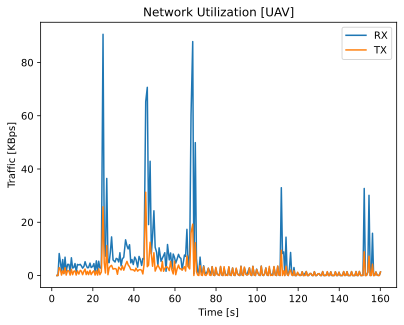

In [44]:
_, aggr_rx_bytes, aggr_tx_bytes = parse_ifconfig_file(OUTER_LOG_DIR + '/0/report-eval-unit_0_0.ifconfig')

fig, ax = plt.subplots()
ax.set_title('Network Utilization [UAV]')
ax.set_ylabel('Traffic [KBps]')
ax.set_xlabel('Time [s]')
    
x, y = aggr_to_xy(aggr_rx_bytes)
ax.plot(x, y / 1000, label="RX")
x, y = aggr_to_xy(aggr_tx_bytes)
ax.plot(x, y / 1000, label="TX")

ax.legend()

display(fig)
plt.close()